In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor



import joblib
sns.set(style='whitegrid')

print("Libraries imported.")


Libraries imported.


In [33]:
df = pd.read_csv("dataProductivity-Prediction-of-Garment-Employeese.csv")
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully.
Shape: (1302, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,NaN,0.0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1.0,0.75,3.94,NaN,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12.0,0.80,11.41,NaN,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6.0,NaN,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


In [34]:
# — Explore data structure

print("*** Dataset Info *** :")
print(df.info())

print("\n*** Missing Values per Column ***:")
print(df.isnull().sum())

print("\n *** Summary Statistics (numeric columns) *** :")
display(df.describe())

print("\n *** Unique values in some key categorical columns ***:")
for col in ['day', 'department', 'quarter']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


*** Dataset Info *** :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1272 non-null   object 
 1   quarter                1279 non-null   object 
 2   department             1275 non-null   object 
 3   day                    1274 non-null   object 
 4   team                   1278 non-null   float64
 5   targeted_productivity  1279 non-null   float64
 6   smv                    1276 non-null   float64
 7   wip                    729 non-null    float64
 8   over_time              1276 non-null   float64
 9   incentive              1275 non-null   float64
 10  idle_time              1275 non-null   float64
 11  idle_men               1278 non-null   float64
 12  no_of_style_change     1279 non-null   float64
 13  no_of_workers          1280 non-null   float64
 14  actual_productivity    1267 non-n

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1278.000000,1279.000000,1276.000000,729.000000,1276.000000,1275.000000,1275.000000,1278.000000,1279.000000,1280.000000,1267.000000
mean,6.443662,0.730274,15.061418,1148.422497,4551.332288,36.967843,0.688235,0.357590,0.146990,34.553906,0.734889
std,3.468331,0.096727,10.989957,1596.736245,3347.164546,155.419707,12.316019,3.191313,0.422717,22.256752,0.173802
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,762.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650173
50%,7.000000,0.750000,15.260000,1040.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.763375
75%,9.000000,0.800000,24.260000,1255.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850354
max,12.000000,0.800000,54.560000,21540.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437



 *** Unique values in some key categorical columns ***:
day: ['Thursday' nan 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
department: ['sweing' 'finishing ' 'finishing' nan]
quarter: ['Quarter1' nan 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


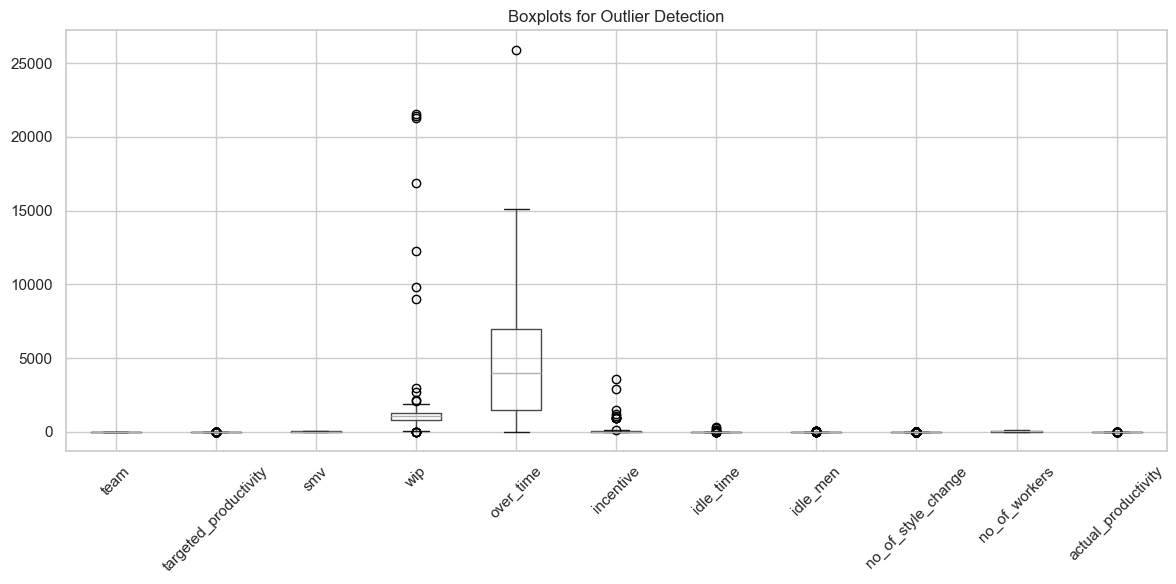

In [35]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])


plt.figure(figsize=(12, 6))
numeric_cols.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots for Outlier Detection")
plt.tight_layout()
plt.show()


In [36]:

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Dictionary to store outliers for each column
outliers_dict = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    # Store in dictionary
    outliers_dict[col] = outliers

    # Print summary
    print(f"➡ {col}: {len(outliers)} outliers, lower_bound={lower_bound}, upper_bound={upper_bound}")



# Remove rows where 'over_time' is outside the bounds
df = df[(df['over_time'] >= -6840.0) & (df['over_time'] <= 15240.0)]
print("outlier removed")

➡ team: 0 outliers, lower_bound=-6.0, upper_bound=18.0
➡ targeted_productivity: 82 outliers, lower_bound=0.5499999999999998, upper_bound=0.9500000000000002
➡ smv: 0 outliers, lower_bound=-26.54, upper_bound=54.74
➡ wip: 17 outliers, lower_bound=22.5, upper_bound=1994.5
➡ over_time: 1 outliers, lower_bound=-6840.0, upper_bound=15240.0
➡ incentive: 11 outliers, lower_bound=-75.0, upper_bound=125.0
➡ idle_time: 19 outliers, lower_bound=0.0, upper_bound=0.0
➡ idle_men: 19 outliers, lower_bound=0.0, upper_bound=0.0
➡ no_of_style_change: 154 outliers, lower_bound=0.0, upper_bound=0.0
➡ no_of_workers: 0 outliers, lower_bound=-63.0, upper_bound=129.0
➡ actual_productivity: 44 outliers, lower_bound=0.34990309974999984, upper_bound=1.1506239017500002
outlier removed


In [37]:
# Strip whitespace in string columns
for col in ['department', 'quarter', 'day']:
    df[col] = df[col].astype(str).str.strip()

# Fix unexpected values in 'quarter'
df['quarter'] = df['quarter'].replace({'Quarter5': 'Quarter4'})

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Impute missing values
# Numeric columns (except 'wip' for now)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('wip')  # handle separately
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

# Categorical columns
cat_cols = ['day', 'department', 'quarter']
for col in cat_cols:
    df[col] = df[col].replace('nan', np.nan)
    df[col] = df[col].fillna(df[col].mode()[0])

# Impute 'wip' with median (less sensitive to outliers)
df['wip'] = df['wip'].fillna(df['wip'].median())

# Drop rows with missing 'actual_productivity' (target)
df = df.dropna(subset=['actual_productivity'])

print("✅ Data cleaned. New shape:", df.shape)
df.head()


✅ Data cleaned. New shape: (1275, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8.0,0.800000,26.16,1108.0,7080.0,98.0,0.0,0.335731,0.0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1.0,0.750000,3.94,1039.5,960.0,0.0,0.0,0.000000,0.0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11.0,0.800000,11.41,968.0,3660.0,50.0,0.0,0.000000,0.0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12.0,0.800000,11.41,1039.5,3660.0,50.0,0.0,0.000000,0.0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6.0,0.730607,25.90,1170.0,1920.0,50.0,0.0,0.000000,0.0,56.0,0.800382


In [38]:
# — Feature engineering

# Per-worker features
df['wip_per_worker'] = df['wip'] / df['no_of_workers']
df['over_time_per_worker'] = df['over_time'] / df['no_of_workers']
df['idle_time_per_worker'] = df['idle_time'] / df['idle_men'].replace(0,1)  # avoid division by zero

# Target variable
target = 'actual_productivity'

# Feature columns
X_cols = df.drop(columns=[target, 'date']).columns.tolist()

print("✅ Feature engineering done. Example of new features:")
display(df[['wip_per_worker', 'over_time_per_worker', 'idle_time_per_worker']].head())


✅ Feature engineering done. Example of new features:


,wip_per_worker,over_time_per_worker,idle_time_per_worker
0,18.779661,120.000000,0.0
1,129.937500,120.000000,0.0
2,31.737705,120.000000,0.0
3,34.081967,120.000000,0.0
4,20.892857,34.285714,0.0


In [39]:
# — Preprocessing + Train/Test split


categorical_cols = ['day', 'department', 'quarter']
numeric_cols = [col for col in X_cols if col not in categorical_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)


X = df[X_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Preprocessing + Train/Test split done.")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


✅ Preprocessing + Train/Test split done.
Train shape: (1020, 16) (1020,)
Test shape: (255, 16) (255,)


In [42]:

# AdaBoost Pipeline
ada_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', AdaBoostRegressor(
        n_estimators=100,
        random_state=42,
        learning_rate=1.0
    ))
])

# Train the model
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_pipeline.predict(X_test)

# Calculate metrics
rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada))
mae_ada = mean_absolute_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

print("AdaBoost Regression Metrics:")
print(f"RMSE: {rmse_ada:.4f}")
print(f"MAE: {mae_ada:.4f}")
print(f"R²: {r2_ada:.4f}")



AdaBoost Regression Metrics:
RMSE: 0.1448
MAE: 0.1075
R²: 0.3472


In [43]:

# AdaBoost
axes[1,1].scatter(y_test, y_pred_ada, alpha=0.5)
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,1].set_title('AdaBoost')
axes[1,1].set_xlabel('Actual')
axes[1,1].set_ylabel('Predicted')



plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [45]:
# — Save the model
import joblib

# Save the tuned Random Forest pipeline
joblib.dump(ada_pipeline, 'tuned_ada_productivity_model.pkl')
print(" ada model saved as 'tuned_ada_productivity_model.pkl'")


 ada model saved as 'tuned_ada_productivity_model.pkl'
